In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, Dropout, Attention, Flatten, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import shap
from tensorflow.keras.losses import Huber

### UTILITY FUNCTIONS

In [8]:
### IBWC file reader
def clean_IBWC_csvs(path,dropcols='End of Interval (UTC-06:00)',value_current="Average (TCM)",
                    value_target="storage",datecol="Start of Interval (UTC-06:00)",start_date='1962-01-01',end_date='2023-12-31'):
    """
    Cleans a csv dataset from the IBWC
    """
    dat = pd.read_csv(path,skiprows=4,skipfooter=1,engine='python')
    try:
        dat.drop(dropcols, inplace=True, axis='columns')
    except:
        print(f'No columns to drop, continuing...')
    dat[datecol] = pd.to_datetime(dat[datecol])
    dat.rename(columns={datecol:"date", value_current:value_target}, inplace=True)
    dat["date"] = pd.to_datetime(dat["date"])
    dat = dat[(dat['date'] >= start_date) & (dat['date'] <= end_date)]
    return dat


In [39]:
def process_data(df, lookback_period=100, lag=3, debug=0, trainyrs=5, valyrs=3):
    if debug:
        print("Initial Data:")
        print(df.head())

    data = df.copy()

    # Ensure the date column is datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Add lagged features dynamically based on the specified lag
    for i in range(1, lag + 1):
        data[f'flow_lag{i}'] = data['flow'].shift(i)
        data[f'total_lag{i}'] = data['total'].shift(i)
        data[f'storage_lag{i}'] = data['storage'].shift(i)
    
    if debug:
        print("\nData with Lagged Features:")
        print(data.head(lag + 2))  # Display more rows to show the lagged features

    # Drop rows with NaN values due to lagging
    data = data.dropna()
    
    if debug:
        print("\nData after Dropping NaN Values:")
        print(data.head())

    # Select features
    feature_columns = [f'flow_lag{i}' for i in range(1, lag + 1)] + \
                      ['total'] + [f'total_lag{i}' for i in range(1, lag + 1)] + \
                      ['storage'] + [f'storage_lag{i}' for i in range(1, lag + 1)] + \
    
    if debug:
        print("\nFeature Columns Selected:")
        print(feature_columns)

    features = data[feature_columns]
    target = data['flow']

    if debug:
        print("\nFeatures DataFrame:")
        print(features.head())
        
        print("\nTarget Series:")
        print(target.head())

    # Perform Z-score normalization using numpy
    feature_means = features.mean(axis=0)
    feature_stds = features.std(axis=0)
    features_scaled = (features - feature_means) / feature_stds

    target_mean = target.mean()
    target_std = target.std()
    target_scaled = (target - target_mean) / target_std

    if debug:
        print("\nNormalized Features DataFrame:")
        print(features_scaled.head())
        
        print("\nNormalized Target Series:")
        print(target_scaled.head())

    # Convert to numpy arrays
    features_scaled = features_scaled.values
    target_scaled = target_scaled.values

    X = []
    y = []

    for i in range(lookback_period, len(features_scaled)):
        X.append(features_scaled[i-lookback_period:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    # Define the indices for the desired train/val/test period
    start_date = data['date'].iloc[0]
    train_end_date = start_date + timedelta(days=365.25*trainyrs)
    val_end_date = train_end_date + timedelta(days=365.25*valyrs)

    train_end_index = data[data['date'] <= train_end_date].index[-1] - lookback_period + 1
    val_end_index = data[data['date'] <= val_end_date].index[-1] - lookback_period + 1

    X_train, X_val, X_test = X[:train_end_index], X[train_end_index:val_end_index], X[val_end_index:]
    y_train, y_val, y_test = y[:train_end_index], y[train_end_index:val_end_index], y[val_end_index:]

    # Extract dates for train, validation, and test sets
    train_dates = data['date'].iloc[:train_end_index + lookback_period]
    val_dates = data['date'].iloc[train_end_index + lookback_period:val_end_index + lookback_period]
    test_dates = data['date'].iloc[val_end_index + lookback_period:]

    # Denorm dictionary for inverse transformation of predictions
    denorm_dict = {
        'feature_means': feature_means,
        'feature_stds': feature_stds,
        'target_mean': target_mean,
        'target_std': target_std,
    }

    dates_dict = {
        'train_dates': train_dates,
        'val_dates': val_dates,
        'test_dates': test_dates
    }

    if debug:
        print("\nFirst 5 rows of Training Data (X_train):")
        print(X_train[:5])
        print("\nFirst 5 rows of Training Targets (y_train):")
        print(y_train[:5])
        
        print("\nDenormalization Dictionary:")
        print(denorm_dict)

        print("\nTraining Date Range:")
        print(train_dates.iloc[0], "to", train_dates.iloc[-1])

        print("\nValidation Date Range:")
        print(val_dates.iloc[0], "to", val_dates.iloc[-1])

        print("\nTest Date Range:")
        print(test_dates.iloc[0], "to", test_dates.iloc[-1])

    return X_train, X_val, X_test, y_train, y_val, y_test, denorm_dict, dates_dict, feature_columns

In [75]:
def process_data(df, laboq_levels, lookback_period=100, lag=3, debug=0, trainyrs=5, valyrs=3):
    if debug < 1:
        print("Initial Data:")
        print(df.head())

    data = df.copy()

    # Ensure the date column is datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Add lagged features dynamically based on the specified lag
    for i in range(1, lag + 1):
        data[f'flow_lag{i}'] = data['flow'].shift(i)
        data[f'total_lag{i}'] = data['total'].shift(i)
        data[f'storage_lag{i}'] = data['storage'].shift(i)
    
    if debug < 1:
        print("\nData with Lagged Features:")
        print(data.head(lag + 2))  # Display more rows to show the lagged features

    # Drop rows with NaN values due to lagging
    data = data.dropna()
    
    if debug < 1:
        print("\nData after Dropping NaN Values:")
        print(data.head())

    # Select features
    feature_columns = [f'flow_lag{i}' for i in range(1, lag + 1)] + \
                      ['total'] + [f'total_lag{i}' for i in range(1, lag + 1)] + \
                      ['storage'] + [f'storage_lag{i}' for i in range(1, lag + 1)]
    
    if debug < 1:
        print("\nFeature Columns Selected:")
        print(feature_columns)

    features = data[feature_columns]
    target = data['flow']

    if debug < 1:
        print("\nFeatures DataFrame:")
        print(features.head())
        
        print("\nTarget Series:")
        print(target.head())

    # Normalize dynamic features
    feature_means = features.mean(axis=0)
    feature_stds = features.std(axis=0)
    features_scaled = (features - feature_means) / feature_stds

    # Normalize target variable
    target_mean = target.mean()
    target_std = target.std()
    target_scaled = (target - target_mean) / target_std

    if debug < 1:
        print("\nNormalized Features DataFrame:")
        print(features_scaled.head())
        
        print("\nNormalized Target Series:")
        print(target_scaled.head())

    # Normalize static features using the storage mean and standard deviation
    storage_mean = feature_means['storage']
    storage_std = feature_stds['storage']
    normalized_static = {key: (value - storage_mean) / storage_std for key, value in laboq_levels.items()}
    
    if debug < 1:
        print("\nNormalized Static Features:")
        print(normalized_static)

    # Add normalized static features to the DataFrame
    for key, value in normalized_static.items():
        features_scaled[key] = value

    if debug:
        print("\nFeatures DataFrame with Normalized Static Features:")
        print(features_scaled.head())

    # Convert to numpy arrays
    features_scaled = features_scaled.values
    target_scaled = target_scaled.values

    X = []
    y = []

    for i in range(lookback_period, len(features_scaled)):
        X.append(features_scaled[i-lookback_period:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    # Define the indices for the desired train/val/test period
    start_date = data['date'].iloc[0]
    train_end_date = start_date + timedelta(days=365.25*trainyrs)
    val_end_date = train_end_date + timedelta(days=365.25*valyrs)

    train_end_index = data[data['date'] <= train_end_date].index[-1] - lookback_period + 1
    val_end_index = data[data['date'] <= val_end_date].index[-1] - lookback_period + 1

    X_train, X_val, X_test = X[:train_end_index], X[train_end_index:val_end_index], X[val_end_index:]
    y_train, y_val, y_test = y[:train_end_index], y[train_end_index:val_end_index], y[val_end_index:]

    # Extract dates for train, validation, and test sets
    train_dates = data['date'].iloc[:train_end_index + lookback_period]
    val_dates = data['date'].iloc[train_end_index + lookback_period:val_end_index + lookback_period]
    test_dates = data['date'].iloc[val_end_index + lookback_period:]

    # Denorm dictionary for inverse transformation of predictions
    denorm_dict = {
        'feature_means': feature_means,
        'feature_stds': feature_stds,
        'target_mean': target_mean,
        'target_std': target_std,
    }

    dates_dict = {
        'train_dates': train_dates,
        'val_dates': val_dates,
        'test_dates': test_dates
    }

    if debug < 1:
        print("\nFirst 5 rows of Training Data (X_train):")
        print(X_train[:5])
        print("\nFirst 5 rows of Training Targets (y_train):")
        print(y_train[:5])
        
        print("\nDenormalization Dictionary:")
        print(denorm_dict)

        print("\nTraining Date Range:")
        print(train_dates.iloc[0], "to", train_dates.iloc[-1])

        print("\nValidation Date Range:")
        print(val_dates.iloc[0], "to", val_dates.iloc[-1])

        print("\nTest Date Range:")
        print(test_dates.iloc[0], "to", test_dates.iloc[-1])

    return X_train, X_val, X_test, y_train, y_val, y_test, denorm_dict, dates_dict, feature_columns + list(laboq_levels.keys())

In [10]:
# Example of inverse transforming the predictions
def denormalize(predictions, denorm_dict):
    return predictions * denorm_dict['target_std'] + denorm_dict['target_mean']

## Phase 1 - Understanding Deliveries in the Rio Grande
#### Goals
* show the historical trajectory of deliveries
* show the response to rainfall
* understand the correlation to runoff
* (explore the 1992 regime shift wrt to precipitation in the historical record)
#### Figures
1. Cumulative deliveries from IBWC
2. Flow at each tributary from IBWC
3. Total precipitation vs reservoir level

In [2]:
### IMPORT ALL DATA ###
# 1. reservoirs
# 2. streamflow & deliveries
# 3. basin total precipitation
# 4. tropical cyclone tracks
# 5. tropical cyclone precipitation

In [11]:
subbasins = gpd.read_file("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/RGB_subbasins/RGB_subbasins.shp")

<Axes: >

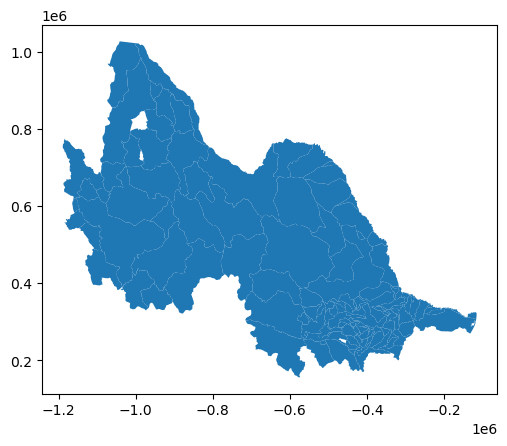

In [12]:
subbasins.plot()

### 1. Exploratory analysis 
Section to visualize the timeseries and relationships between these variables

### 2. Feature Selection
Section to perform feature selection, analysing the relationships, autocorrelation and parameters that could be fed to the LSTM.

## Phase 2 - LSTM Prediction
#### Goals
* build a model to predict streamflow at each tributary, using some combination of the following variables
    1. Basin total precipitation
    2. Tropical cyclone precipitation
    3. Sub-basin precipitation
    4. Reservoir levels
    5. Static conservation pool for each reservoir
    6. ERA5 average surface temperature in subbasin (?)
    7. Daymet average temperature at reservoirs

## Testing on the Conchos
The following section is a test of the model for the Rio Conchos, using La Boquilla as our upstream reservoir that the model is trying to learn. We first conduct an extremely simple test with no TCs and the basic parameters and model set up.
### 1. No awareness of TCs or subbasins
* Training the LSTM model to predict the flow at each tributary

In [13]:
#### IMPORTING DATA FOR THE CONCHOS ####
# Conchos streamflow
conchos_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/conchos_discharge.csv",
                              value_current="Average (m^3/d)",value_target="flow",start_date='2000-06-01',end_date='2019-12-31')
# La Boquilla storage
laboq_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/la_boquilla_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="storage",start_date='2000-06-01',end_date='2019-12-31')
# Conchos daymet
# Basin precip
rgb_precip = pd.read_csv("/Users/laratobias-tarsh/Documents/SEAS_hydro/mexico_basin_totals.csv")
rgb_precip_total = rgb_precip.drop(['idx','non_tc','tc'],axis='columns')
rgb_precip_total['date'] = pd.to_datetime(rgb_precip_total['date'])

No columns to drop, continuing...


In [31]:
cons_storage = {'Amistad':3980096,
                'La Boquilla':2893571,
                'Falcon':3288726 }

dead_storage = {'Amistad':40358,
                'La Boquilla':106087,
                'Falcon':12 }

flood_storage = {'Amistad':6055720,
                'La Boquilla':3208267,
                'Falcon':3923322 }

laboq_levels = {'dead':106087,
                'flood':3208267,
                'conservation':2893571}

#### Prepare the data for machine learning

In [50]:
##### CONCAT DATA #####
merged_df = pd.merge(conchos_dis, rgb_precip_total, on='date')
ml_data = pd.merge(merged_df, laboq_stor, on='date')
# Create a DataFrame from the dictionary values
#repeated_values = pd.DataFrame({key: [value] * len(ml_data) for key, value in laboq_levels.items()})
# Concatenate the original DataFrame with the repeated values DataFrame
#ml_data = pd.concat([ml_data, repeated_values], axis=1)
ml_data.head()

,date,flow,total,storage
0,2000-06-01,1693451.00,8204.1100,892460.0
1,2000-06-02,1140487.41,12233.2940,893150.0
2,2000-06-03,1123207.29,12556.9890,891100.0
3,2000-06-04,2574736.72,8336.3850,889050.0
4,2000-06-05,2168654.08,7789.0293,886320.0


In [76]:
#### SPLIT INTO TRAINING AND TESTING #####
# Call the process_data function
lookback_period = 365
X_train, X_val, X_test, y_train, y_val, y_test, denorm_dict, dates_dict, feature_cols = process_data(ml_data, laboq_levels, lookback_period=lookback_period, 
                                                                                                     trainyrs=10,valyrs=1,lag=7,debug=1)



Features DataFrame with Normalized Static Features:
    flow_lag1  flow_lag2  flow_lag3  flow_lag4  flow_lag5  flow_lag6  \
7    0.037273   0.092951   0.166122   0.240870  -0.026443  -0.023257   
8   -0.059789   0.037260   0.092928   0.166086   0.240873  -0.026440   
9    0.045229  -0.059802   0.037237   0.092892   0.166089   0.240876   
10   0.075461   0.045216  -0.059825   0.037201   0.092895   0.166091   
11   0.070688   0.075448   0.045193  -0.059860   0.037204   0.092898   

    flow_lag7     total  total_lag1  total_lag2  ...  storage_lag1  \
7    0.078566 -0.022918   -0.306201   -0.018110  ...     -1.062739   
8   -0.023269  0.530602   -0.022939   -0.306281  ...     -1.067358   
9   -0.026451  0.917595    0.530585   -0.023013  ...     -1.069214   
10   0.240865 -0.025486    0.917582    0.530523  ...     -1.072709   
11   0.166080  0.189084   -0.025507    0.917527  ...     -1.077098   

    storage_lag2  storage_lag3  storage_lag4  storage_lag5  storage_lag6  \
7      -1.058747 

In [70]:
print(f'Shape of X_train: {X_train.shape}')

Shape of X_train: (3295, 365, 26)


In [81]:
# Define and compile model
model = Sequential()
model.add(LSTM(units=64, activation="tanh",return_sequences=True, input_shape=(lookback_period, X_train.shape[2])))
model.add(Dropout(0.4))
model.add(LSTM(units=32,activation="softmax"))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss=Huber(delta=1.5), optimizer='adam', metrics=['mean_absolute_error'])
#model.compile(loss='mae', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'\nTest Loss: {test_loss}')


Epoch 1/20
103/103 [==============================] - 14s 126ms/step - loss: 0.2413 - mean_absolute_error: 0.3134 - val_loss: 0.0272 - val_mean_absolute_error: 0.1408
Epoch 2/20
103/103 [==============================] - 13s 126ms/step - loss: 0.2263 - mean_absolute_error: 0.2786 - val_loss: 0.0299 - val_mean_absolute_error: 0.1543
Epoch 3/20
103/103 [==============================] - 13s 126ms/step - loss: 0.2237 - mean_absolute_error: 0.2735 - val_loss: 0.0260 - val_mean_absolute_error: 0.1205
Epoch 4/20
103/103 [==============================] - 13s 123ms/step - loss: 0.2203 - mean_absolute_error: 0.2697 - val_loss: 0.0211 - val_mean_absolute_error: 0.1135
Epoch 5/20
103/103 [==============================] - 13s 124ms/step - loss: 0.2163 - mean_absolute_error: 0.2729 - val_loss: 0.0280 - val_mean_absolute_error: 0.1741
Epoch 6/20
103/103 [==============================] - 13s 129ms/step - loss: 0.2185 - mean_absolute_error: 0.2747 - val_loss: 0.0198 - val_mean_absolute_error: 0.127

In [82]:
# Assume `predictions` are some predictions made by the model
predictions = model.predict(X_test)
denormalized_predictions = denormalize(predictions, denorm_dict)
denormalized_ytest = denormalize(y_test,denorm_dict)
print("\nDenormalized Predictions:")
print(denormalized_predictions)

98/98 [==============================] - 3s 32ms/step

Denormalized Predictions:
[[180781.12]
 [175172.75]
 [170119.75]
 ...
 [626442.  ]
 [619465.5 ]
 [610085.1 ]]


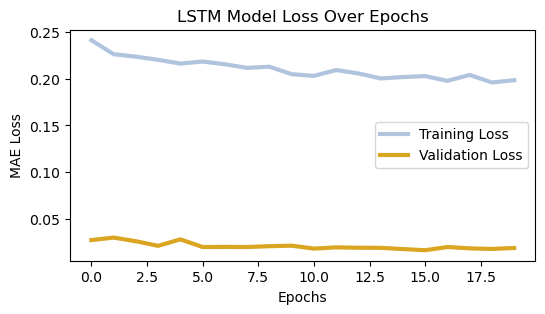

In [83]:
#Plot the loss curve
fig2, ax2 = plt.subplots(1,1,figsize=(6,3))
ax2.plot(history.history['loss'], lw=3, label='Training Loss', c= 'lightsteelblue')
ax2.plot(history.history['val_loss'], lw=3, label='Validation Loss', c= 'goldenrod')
ax2.set_title('LSTM Model Loss Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE Loss')
ax2.legend()

Text(0, 0.5, 'Daily Streamflow (TCM)')

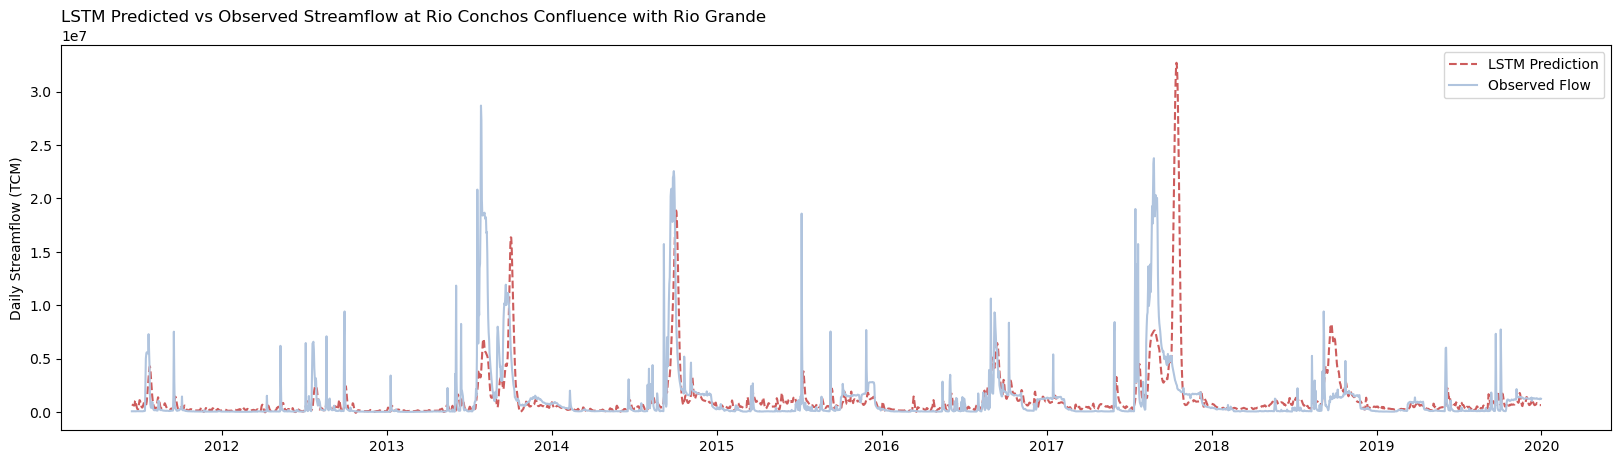

In [69]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(dates_dict['test_dates'],denormalized_predictions,ls='--',c='indianred',label='LSTM Prediction')
ax.plot(dates_dict['test_dates'],denormalized_ytest,ls='-',c='lightsteelblue',label='Observed Flow')
ax.legend()
ax.set_title('LSTM Predicted vs Observed Streamflow at Rio Conchos Confluence with Rio Grande',loc='left')
ax.set_ylabel('Daily Streamflow (TCM)')

Text(0, 0.5, 'Daily Streamflow (TCM)')

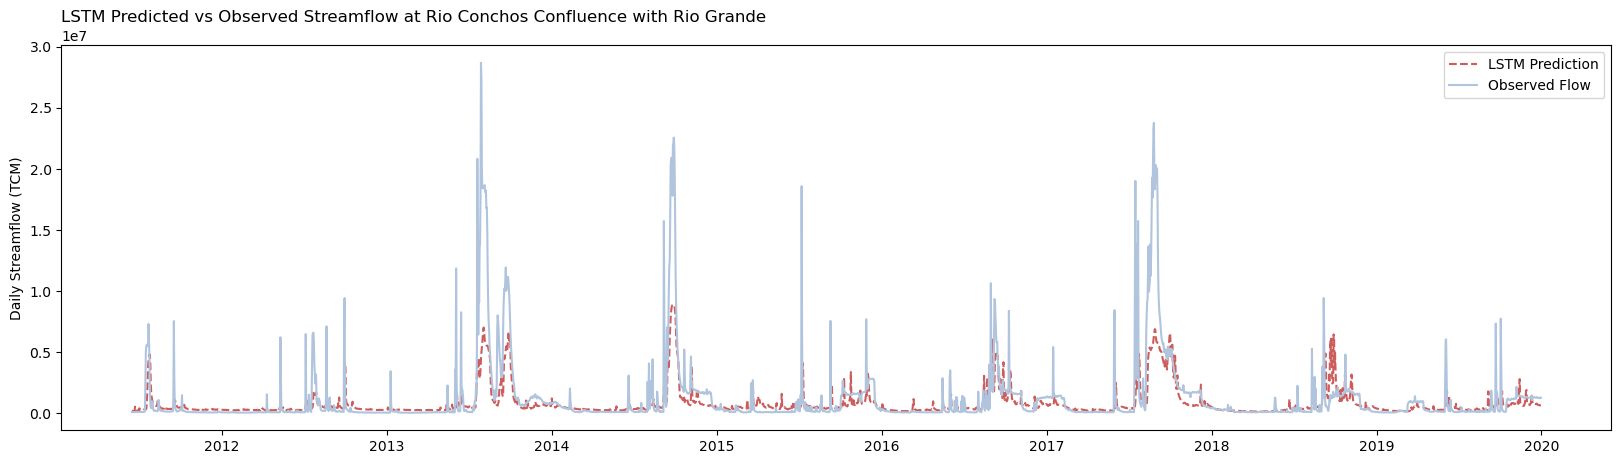

In [84]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(dates_dict['test_dates'],denormalized_predictions,ls='--',c='indianred',label='LSTM Prediction')
ax.plot(dates_dict['test_dates'],denormalized_ytest,ls='-',c='lightsteelblue',label='Observed Flow')
ax.legend()
ax.set_title('LSTM Predicted vs Observed Streamflow at Rio Conchos Confluence with Rio Grande',loc='left')
ax.set_ylabel('Daily Streamflow (TCM)')

In [22]:
explainer = shap.DeepExplainer(model, X_train[:10])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

In [31]:
# Define prediction function
def predict_fn(data):
    data_reshaped = data.reshape(data.shape[0], X_train.shape[1], X_train.shape[2])
    return model.predict(data_reshaped)

# Check data shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Reshape testing data to 2D for KernelExplainer
X_test_2d = X_test.reshape((X_test.shape[0], -1))

# Use shap.sample to create a smaller background sample
background_sample = shap.sample(X_train, 10)
background_sample_2d = background_sample.reshape((background_sample.shape[0], -1))

# Initialize KernelExplainer with flattened background data
explainer = shap.KernelExplainer(predict_fn, background_sample_2d)

# Explain the first 10 predictions
shap_values = explainer.shap_values(X_test_2d[:10])

# Verify shapes of shap_values
print("Shape of X_test:", X_test.shape)
print("Shape of shap_values:", np.array(shap_values).shape)

# Flatten the dataset for plotting (samples, timesteps * features)
X_test_flat = X_test_2d[:10]  # Since already 2D, no need to flatten further

# Plot the summary plot with flattened data
shap.summary_plot(shap_values, X_test_flat)

# Optional: visualize dependence and force plots
# Example: For the 0th feature
feature_index = 0  # Example feature index
shap.dependence_plot(feature_index, shap_values, X_test_flat)

instance_index = 0  # Example instance index
shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test_flat[instance_index])

Shape of X_train: (3295, 365, 23)
Shape of X_test: (3121, 365, 23)


  0%|          | 0/10 [00:00<?, ?it/s]